Hunter Bennett | Glass Lab | Brain Aging Project | 27 Feb 2021

Goal of this analysis is to compare promoter acetylation in 4 month microglia to gene expression in 4 month microglia as a way of justifying the use of promoter acetylation as a proxy for gene expression.

Things to add:
* Try calculating correlations the way inge does it where we look at pairwise correlations for intra-cell type versus pairwise correlations for non-cell type

In [16]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set working paths

In [14]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/'
workingDirectory = '/home/h1bennet/brain_aging/results/04_Young_Cell_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

Read in color scheme dictionary

In [3]:
hex_dict={}
rgb_dict={}
for line in open('/home/h1bennet/brain_aging/data/brain_aging_color_table.txt','r'):
    split = line.strip().replace('\ufeff','').split('\t')
    # split2 = split[1]
    hex_dict[split[0]] = split[1]
    rgb_dict[split[0]] = split[2]    

# Call differential acetylation

In [9]:
if not os.path.isdir('./diff_promoters/'):
    os.mkdir('./diff_promoters/')

We have already filtered poor quality samples but we should also filter duplicated promoters to make analysis cleaner.. we will just filter based on mean H3K27Ac since we have many different cell types.

In [48]:
df.columns.str.contains('ChIP_H3K27ac')

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [51]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_promoters.txt')

print(mat.shape[0], 'Unfiltered promoters')

df['mean'] = df.loc[:, df.columns.str.contains('ChIP_H3K27ac')].mean(1)
df = df.sort_values('mean', ascending=False)
df = df.drop(columns='mean')
# filter duplicates, keeping the first instance has highest average expression
df_filt = df.loc[~df['Gene Name'].duplicated(), :]
print(df_filt.shape[0], 'Filtered promoters')

df_filt.to_csv('./merged_peaks/ann_norm_promoters_highest_avg_expression.txt',
          sep='\t')

39409 Unfiltered promoters
23801 Filtered promoters


In [52]:
%%bash
source activate deseq_36
getDiffExpression.pl ./merged_peaks/ann_norm_promoters_highest_avg_expression.txt \
00_olig2 00_olig2 00_olig2 \
01_neun 01_neun 01_neun 01_neun 01_neun \
02_pu1 02_pu1 02_pu1 \
03_sox9 03_sox9 \
-peaks -AvsA > ./diff_promoters/diff_output.txt


	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats 00_olig2 vs. 01_neun:
		Total Genes: 23801
		Total Up-regulated in 01_neun vs. 00_olig2: 4391 (18.449%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 01_neun vs. 00_olig2: 2817 (11.836%) [log2fold<-1, FDR<0.05]
	Output Stats 00_olig2 vs. 02_pu1:
		Total Genes: 23801
		Total Up-regulated in 02_pu1 vs. 00_olig2: 2806 (11.789%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 02_pu1 vs. 00_olig2: 3225 (13.550%) [log2fold<-1, FDR<0.05]
	Output Stats 00_olig2 vs. 03_sox9:
		Total Genes: 23801
		Total Up-regulated in 03_sox9 vs. 00_olig2: 1965 (8.256%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in 03_sox9 vs. 00_olig2: 2498 (10.495%) [log2fold<-1, FDR<0.05]
	Output Stats 01_neun vs. 02_pu1:
		Total Genes: 23801
		Total Up-regulated in 02_pu1 vs. 01_neun: 4270 (17.940%) [log2fold>1, FDR<0.05]
		Total Dn-r

## Import differential peaks

In [64]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_promoters/diff_output.txt',
    './merged_peaks/ann_norm_promoters.txt')


annotatePeaks all peaks (41585, 31)
getDiffExpression selected transcripts (23801, 49)
annotatePeaks selected peaks (23801, 31)


check differential peak calling on browser

In [65]:
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)
diff_peak.sort_values('00_olig2 vs. 02_pu1 adj. p-value', ascending=True).head()

,Chr,Start,End,Strand,Not Used,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,01_neun vs. 02_pu1 Log2 Fold Change,01_neun vs. 02_pu1 p-value,01_neun vs. 02_pu1 adj. p-value,01_neun vs. 03_sox9 Log2 Fold Change,01_neun vs. 03_sox9 p-value,01_neun vs. 03_sox9 adj. p-value,02_pu1 vs. 03_sox9 Log2 Fold Change,02_pu1 vs. 03_sox9 p-value,02_pu1 vs. 03_sox9 adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
NM_011129,chr11,87579061,87583061,+,0,NaN,promoter-TSS (NM_011129),promoter-TSS (NM_011129),0,NM_011129,...,-1.775012,8.958720e-08,3.799595e-07,1.011527,1.258041e-04,5.602066e-04,2.731281,4.795403e-10,4.118015e-09,chr11:87579061-87583061
NM_023320,chr3,95993839,95997839,-,0,NaN,promoter-TSS (NM_023320),promoter-TSS (NM_023320),0,NM_023320,...,2.017406,1.028832e-71,6.825165e-70,-1.268811,2.707670e-15,3.207235e-14,-3.347901,4.821186e-59,1.197950e-56,chr3:95993839-95997839
NM_020568,chr17,56107802,56111802,-,0,NaN,promoter-TSS (NM_020568),promoter-TSS (NM_020568),0,NM_020568,...,-2.235111,1.406884e-09,6.750249e-09,3.390348,1.654183e-61,2.799115e-59,5.583827,1.196823e-50,1.322568e-48,chr17:56107802-56111802
NR_077238,chr17,10454216,10458216,+,0,NaN,promoter-TSS (NR_077238),promoter-TSS (NR_077238),0,NR_077238,...,1.265041,1.565537e-02,3.328241e-02,1.642291,4.266299e-03,1.360827e-02,0.311993,6.383765e-01,7.940089e-01,chr17:10454216-10458216
NM_001177647,chr2,129591169,129595169,+,0,NaN,promoter-TSS (NM_001291021),promoter-TSS (NM_001291021),0,NM_001177647,...,1.121000,1.736295e-18,1.323911e-17,-0.539693,1.175576e-04,5.267525e-04,-1.717381,1.038066e-17,1.508338e-16,chr2:129591169-129595169


Extract comparisons as dictionary

In [66]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [67]:
comps = ['00_olig2 vs. 01_neun',
         '00_olig2 vs. 02_pu1',
         '00_olig2 vs. 03_sox9',
         '01_neun vs. 02_pu1',
         '01_neun vs. 03_sox9',
         '02_pu1 vs. 03_sox9']

groups = [[[0,1,2],[3,4,5,6,7]],
        [[0,1,2],[8,9,10]],
        [[0,1,2],[11,12]],
        [[3,4,5,6,7],[8,9,10]],
        [[3,4,5,6,7],[11,12]],
        [[8,9,10],[11,12]]]

cols = []
for i in groups:
    subcols = []
    for j in i:
        subcols.extend([k for k in j])
    cols.append(subcols)

colors = [['#31a354', '#dd1c77'],
          ['#31a354', '#3182bd'],
          ['#31a354', '#e6550d'],
          ['#dd1c77', '#3182bd'],
          ['#dd1c77', '#e6550d'],
          ['#3182bd', '#e6550d']]

Plot differential enhancer acetylation

00_olig2 vs. 01_neun
N genes downregulated 2817
N genes upregulated 4391

00_olig2 vs. 02_pu1
N genes downregulated 3225
N genes upregulated 2806

00_olig2 vs. 03_sox9
N genes downregulated 2498
N genes upregulated 1965

01_neun vs. 02_pu1
N genes downregulated 5115
N genes upregulated 4270

01_neun vs. 03_sox9
N genes downregulated 3869
N genes upregulated 3271

02_pu1 vs. 03_sox9
N genes downregulated 2745
N genes upregulated 2424



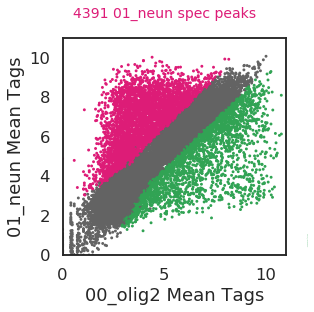

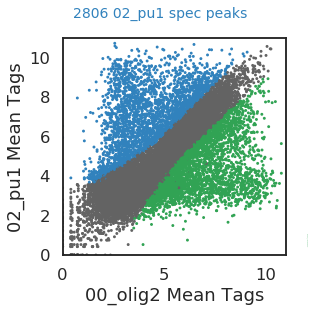

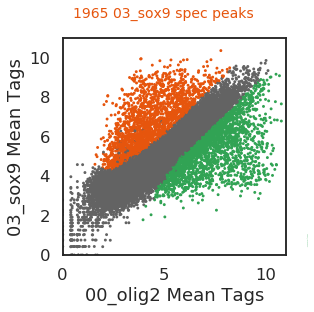

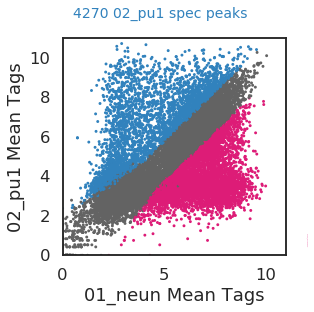

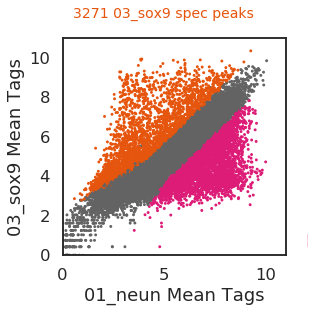

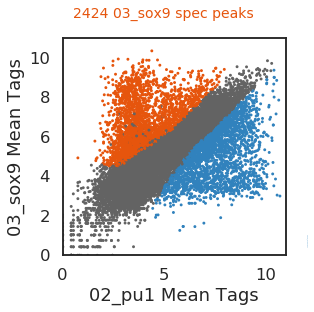

In [68]:
fc = 1
pval = 0.05

for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')

    de = comp_dict[key]
    ## filter lowly expressed peaks
    # filtered = (peak_mat.iloc[:, group[0]].mean(1) >= 5) | (peak_mat.iloc[:, group[1]].mean(1) >= 5)
    # de = de.reindex(peak_mat.index[filtered]).dropna()
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)))
    print('N genes upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
    # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=2, #de.log10p+0.05,
        c=dot_colors)

    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,12,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc > fc)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(12,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)), key.split(' vs. ')[0]),
        fontsize=1,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

Extract cell type specific promoters

In [69]:
# initialize dict and list of cell types
promoter_lists = {}
cells = ['olig2',
         'neun',
         'pu1',
         'sox9']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        promoter_lists[cell+'_union'] = u
        promoter_lists[cell+'_intersection'] = i

Analyzing olig2 ...

0
For comp: 00_olig2 vs. 01_neun
Union set at: 2817 peaks
Intersection set at: 2817 peaks

1
For comp: 00_olig2 vs. 02_pu1
Union set at: 4602 peaks
Intersection set at: 1440 peaks

2
For comp: 00_olig2 vs. 03_sox9
Union set at: 5159 peaks
Intersection set at: 1052 peaks

3
For comp: 01_neun vs. 02_pu1
Union set at: 5159 peaks
Intersection set at: 1052 peaks

3
For comp: 01_neun vs. 03_sox9
Union set at: 5159 peaks
Intersection set at: 1052 peaks

3
For comp: 02_pu1 vs. 03_sox9
Union set at: 5159 peaks
Intersection set at: 1052 peaks

Analyzing neun ...

0
For comp: 00_olig2 vs. 01_neun
Union set at: 4391 peaks
Intersection set at: 4391 peaks

1
For comp: 00_olig2 vs. 02_pu1
Union set at: 4391 peaks
Intersection set at: 4391 peaks

1
For comp: 00_olig2 vs. 03_sox9
Union set at: 4391 peaks
Intersection set at: 4391 peaks

1
For comp: 01_neun vs. 02_pu1
Union set at: 6357 peaks
Intersection set at: 3149 peaks

2
For comp: 01_neun vs. 03_sox9
Union set at: 6839 peaks
I

Write out as gene lists

In [76]:
for key in promoter_lists.keys():
    # grab gene names associated with refseq ids
    genes = diff_peak['Gene Name'].reindex(promoter_lists[key]).dropna(how='all')
    # write out to list for metascape
    with open('./diff_promoters/'+key+'_geneids.txt', 'w') as f:
        f.write('Gene\n')
        for gene in genes:
              f.write(gene+'\n')

# Read in annotated promoters

Mouse promoters

In [4]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_promoters.txt')

# # try with dropped sample
dropsamp = ['XXX']
drop_files = mat.columns[mat.columns.str.contains('|'.join(dropsamp))]
df = df.drop(drop_files, axis=1)

# pull gene name for merging - capitalize to match human gene names
df = df.set_index('Gene Name')
df.index = df.index.str.upper()

# extract just tag counts
mat = df.loc[:, df.columns.str.contains('Brain_MPSIIIA')]

In [5]:
df.head()

,Chr,Start,End,Strand,Not Used,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_1_AL_l20200925_ACAGGCGC_CTCTGCCT,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_2_AL_l20200925_GAACCGCG_TGACCTTA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_3_AL_l20200925_TGCGAGAC_CATTGTTG,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_4_AL_20201111_AACTGTAG_ACGCCGCA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/NeuN/WT/04_mouse_MPSIIIAhet_M_4month_NeuN_ChIP_H3K27ac_5_AL_20201121_TACCGAGG_CCTGAACT,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_1_AL_20200925_CATAGAGT_TGCCACCA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_2_AL_20201121_AATGCCTC_TCGATCCA
Gene Name,,,,,,,,,,,,,,,,,,,,,
EIF4A1,chr11,69670423,69674423,-,0,NaN,promoter-TSS (NM_144958),promoter-TSS (NM_144958),0,NM_144958,...,247.22,250.52,247.06,266.24,136.59,205.93,171.62,139.22,113.46,140.58
MIA2,chr12,59093800,59097800,+,0,NaN,promoter-TSS (NM_177321),promoter-TSS (NM_177321),0,NM_001329047,...,2.17,4.15,1.79,2.96,10.51,11.96,4.11,9.55,11.98,7.51
RHBDD1,chr1,82314579,82318579,+,0,NaN,promoter-TSS (NM_029777),promoter-TSS (NM_029777),0,NM_029777,...,108.12,101.04,107.75,111.43,69.51,114.26,119.21,73.70,62.02,103.73
SGCE,chr6,4745204,4749204,-,0,NaN,promoter-TSS (NM_001130191),promoter-TSS (NM_001130191),0,NM_001130188,...,128.77,117.65,97.04,75.93,53.34,73.07,53.44,46.41,31.71,58.01
ABRAXAS1,chr5,100818935,100822935,-,0,NaN,promoter-TSS (NM_172405),promoter-TSS (NM_172405),0,NM_172405,...,61.94,60.90,50.60,48.32,37.18,49.16,22.61,20.47,28.89,24.57
